In [1]:
import time
from math import log as mlog

import numpy as np
MINF = -np.inf

from scipy import special, integrate

import emcee
import corner

from astropy.visualization import hist as ahist
from astropy import units as u

In [2]:
%matplotlib inline
from matplotlib import rcParams, style
from matplotlib import pyplot as plt

rcParams['image.cmap'] = 'viridis'
rcParams['image.origin'] = 'lower'
rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']
rcParams['figure.figsize'] = (14, 8)
rcParams['axes.titlesize'] =  rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] =  rcParams['ytick.labelsize'] = 14

Consider a dataset that is Normal with $\sigma=1$.  We want to compare models where sigma is a free parameter but mu is either fixed (at 0) or a free parameter, for datasets that are or are not actually at $\mu=0$.

In [3]:
ndata = 15

In [4]:
data0 = np.random.randn(ndata)
data1 = np.random.randn(ndata) + .1
data2 = np.random.randn(ndata) + 2

# First compute the posterior for the parameters of the two models for each of the datasets analytically

In [5]:
GAUSS_TERM = -0.5*mlog(2*np.pi)
def gauss_lnp(data, mu, sig):
    return -0.5 * (((data - mu) / sig) ** 2 + 2 * np.log(sig)) + GAUSS_TERM

$P(\theta|D,M) = P(\theta|M)P(D|\theta,M)/P(D|M)$

$P(D|\theta,M) = \mathcal{L}$

For now we'll assume uniform priors $P(\sigma|M)=U(0,2)$ and $P(\mu|M)=U(-1,1)$

In [6]:
mus = np.linspace(-3, 3, 200)
sigs = np.linspace(0, 2, 201)[1:]
mug, sigg = np.meshgrid(mus, sigs)

## Single parameter model

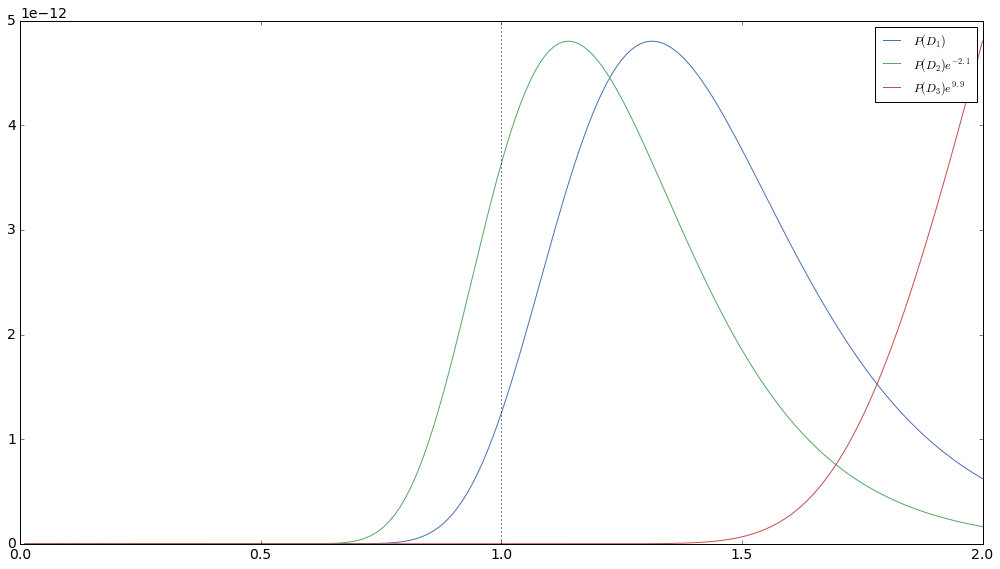

In [8]:
lnlike0_0 = np.sum(gauss_lnp(data0, 0, sigs[:, np.newaxis]), axis=-1)
lnlike0_1 = np.sum(gauss_lnp(data1, 0, sigs[:, np.newaxis]), axis=-1)
lnlike0_2 = np.sum(gauss_lnp(data2, 0, sigs[:, np.newaxis]), axis=-1)
lnpri = -np.log(np.max(sigs)-np.min(sigs))

max0 = np.max(lnlike0_0)
max1 = np.max(lnlike0_1)
max2 = np.max(lnlike0_2)

plt.plot(sigs, np.exp(lnpri + lnlike0_0), label='$P(D_1)$')
plt.plot(sigs, np.exp(lnpri + lnlike0_1 + max0 - max1), label='$P(D_2)  e^{{ {:.1f} }}$'.format(max0-max1))
plt.plot(sigs, np.exp(lnpri + lnlike0_2 + max0 - max2), label='$P(D_3)  e^{{ {:.1f} }}$'.format(max0-max2))
plt.axvline(1, color='k', ls=':')
plt.xlim(0, 2)
plt.legend()

plt.tight_layout()

### Evidence 

$\int \frac{1}{\sqrt{2 \sigma^2 \pi}} e^{\frac{-x^2}{2 \sigma ^2}} d\sigma = - \frac{ Ei\left( -\frac{x^2}{2 \sigma^2} \right)}{2 \sqrt{2 \pi}}$

$\int_a^b = \frac{ Ei\left( -\frac{x^2}{2 a^2} \right) - Ei\left( -\frac{x^2}{2 b^2} \right)}{2 \sqrt{2 \pi}}$

In [97]:
#uniform prior [a, b]
intsig = lambda x, a,b:((8*np.pi)**-0.5)*(special.expi(-0.5*(x/np.array(a))**2)-special.expi(-0.5*(x/np.array(b))**2))

In [103]:
np.log(intsig(data0, 0, 2)).sum()

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


-16.547335322957

### Sanity-check: does the integral above make sense? 

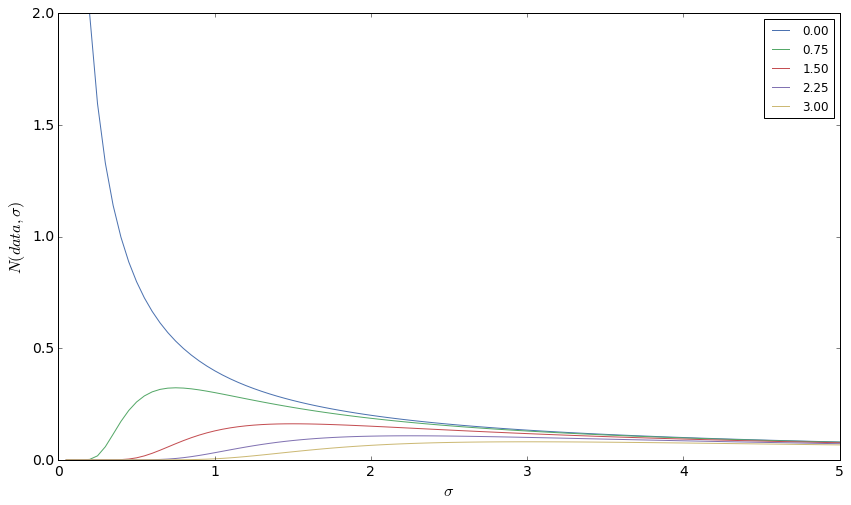

In [123]:
s = np.linspace(0, 5, 101)[1:]
for x in np.linspace(0,3,5):
    plt.plot(s, (2*s**2 * np.pi)**-0.5*np.exp(-0.5*(x/s)**2), label='{:.2f}'.format(x))
plt.ylim(0,2)
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$N(data, \sigma)$')
plt.legend(loc=0)

As long as x!=0 it's OK.  Also, setting a fairly strong prior like $\sigma$ on [0, 2] is OK, *only* if the prior below has the same range.

## Double-parameter model 

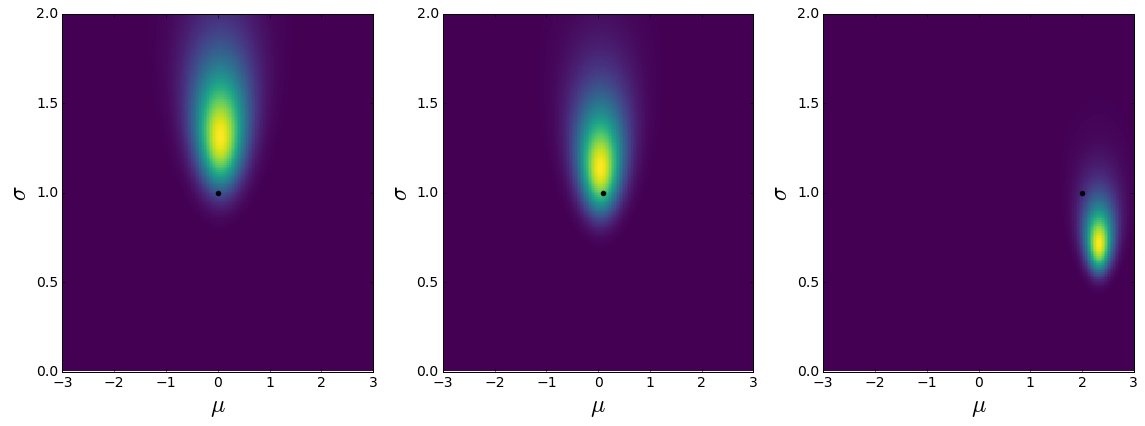

In [9]:
lnlike1_0 = np.sum(gauss_lnp(data0, mug[..., np.newaxis], sigg[..., np.newaxis]), axis=-1)
lnlike1_1 = np.sum(gauss_lnp(data1, mug[..., np.newaxis], sigg[..., np.newaxis]), axis=-1)
lnlike1_2 = np.sum(gauss_lnp(data2, mug[..., np.newaxis], sigg[..., np.newaxis]), axis=-1)
lnpri = -np.log(np.max(sigs)-np.min(sigs)) - np.log(np.max(mus)-np.min(mus))

fig, axs = plt.subplots(1, 3, figsize=(16,6))
ax1, ax2, ax3 = axs
ax1.pcolor(mug, sigg, np.exp(lnlike1_0 + lnpri))
ax1.scatter([0], [1], c='k')
ax2.pcolor(mug, sigg, np.exp(lnlike1_1 + lnpri))
ax2.scatter([0.1], [1], c='k')
ax3.pcolor(mug, sigg, np.exp(lnlike1_2 + lnpri))
ax3.scatter([2.0], [1], c='k')

for ax in axs:
    ax.set_xlabel(r'$\mu$', fontsize=24)
    ax.set_ylabel(r'$\sigma$', fontsize=24)
    ax.set_xlim(-3, 3)
    ax.set_ylim(0, 2)

plt.tight_layout()

## Evidence 

In [140]:
#uniform priors s=[a, b], mu=[c, d]
def intdbl(x, a, b, c, d):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    d = np.array(d)
    def singleint(x, a, b, m):
        eiterm = special.expi(-0.5*(x/a)**2)-special.expi(-0.5*(x/b)**2)
        return eiterm*(m - x) + (2*np.pi)**0.5 * (b*special.erf(2**-0.5*(m-x)/b)- a*special.erf(2**-0.5*(m-x)/a))
    return  (8*np.pi)**-0.5 * (singleint(x, a, b, d) - singleint(x, a, b, c))

In [146]:
np.prod(intdbl(data0,0,2,-2,2))

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in true_divide
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in true_divide


2648288.0123935058

In [142]:
intsig(data0, 0, 2)

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


array([ 0.30970197,  1.26697101,  1.01984322,  0.09705795,  0.55800931,
        0.4116297 ,  0.67813706,  0.1727094 ,  1.31553564,  0.33689896,
        0.0702103 ,  0.45165056,  0.39382045,  0.06692016,  0.16821546])

# Bits and Pieces 

## Map out how likelihood evolves with growing dataset 

[-1.05108875  3.01095596 -0.39002652  0.24901729  0.93097659  0.10661104
 -0.38406668 -0.66388871  0.61376795 -0.08639087]


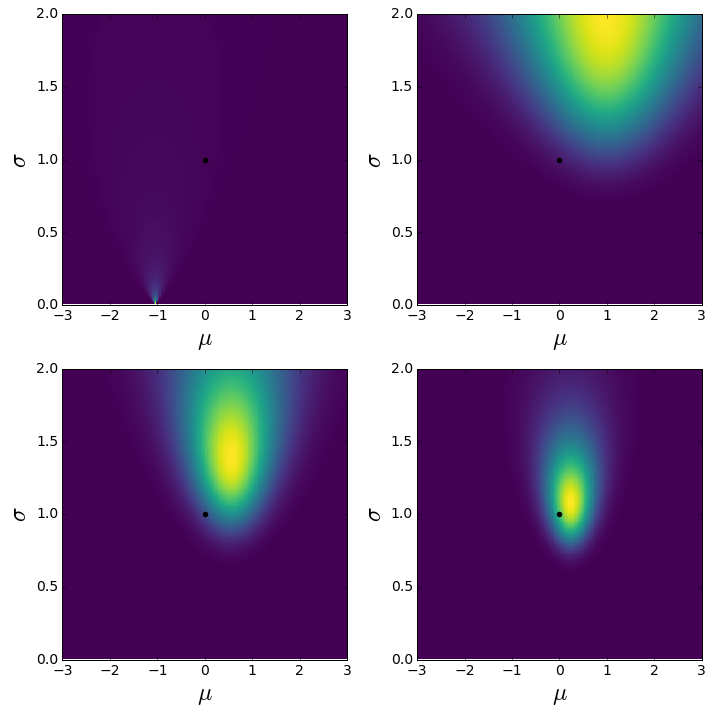

In [10]:
datas = np.random.randn(10)
print(datas)
lnlike0 = np.sum(gauss_lnp(datas[:1], mug[..., np.newaxis], sigg[..., np.newaxis]), axis=-1)
lnlike1 = np.sum(gauss_lnp(datas[:2], mug[..., np.newaxis], sigg[..., np.newaxis]), axis=-1)
lnlike2 = np.sum(gauss_lnp(datas[:5], mug[..., np.newaxis], sigg[..., np.newaxis]), axis=-1)
lnlike3 = np.sum(gauss_lnp(datas[:10], mug[..., np.newaxis], sigg[..., np.newaxis]), axis=-1)
lnpri = -np.log(np.max(sigs)-np.min(sigs)) - np.log(np.max(mus)-np.min(mus))

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
(ax1, ax2), (ax3, ax4) = axs
ax1.pcolor(mug, sigg, np.exp(lnlike0 + lnpri))
ax2.pcolor(mug, sigg, np.exp(lnlike1 + lnpri))
ax3.pcolor(mug, sigg, np.exp(lnlike2 + lnpri))
ax4.pcolor(mug, sigg, np.exp(lnlike3 + lnpri))

for ax in axs.ravel():
    ax.set_xlabel(r'$\mu$', fontsize=24)
    ax.set_ylabel(r'$\sigma$', fontsize=24)
    ax.set_xlim(-3, 3)
    ax.set_ylim(0, 2)
    ax.scatter([0], [1], c='k')

plt.tight_layout()